# Final_PJT 

1. 데이터 summary & read
<br></br>
2. EDA
- 고객
  - 고객 state에 따른 분포도
  - 가격별 고객 state 
  - 배송비별 고객 state
  - city에 따른 고객 분포도

- 상품
  - 상관계수
  - 카테고리별 주문 수
  - 지역별 best 상품
  - 카테고리별 상품 수
  - 상품 크기 분포

- 주문
  - 주문별 결제 수단
  - 주문 상태'취소'
  - 일자(년도, 월, 요일, 시간)에 따른 주문건수
  - 지역(state, city)에 따른 주문건수

- 판매
  - state별 판매자 분포
  - 카테고리 판매량
  - seller_id별 상품판매
  - 상품판매에 따른 매출
  - 상품유통서비스세(tax) 와 review_score, price, freight_value, customer_state_code, seller_state_code, customer unique id

- 금액
  - 주문별 결제수단 확인
  - 날짜에 따른 가격변화
  
- 리뷰
  - 리뷰 평점 분포
  - WordCloud
  - review_score기준 데이터 분리 후 N-Gram 분석
  
- 배송
  - order_status를 활용한 분석
  - 배송날짜에 따른 유통과정 date 파악
  - 날짜에 따른 배송상태
  - 배송지역
<br></br>

---

## 1. 데이터 summary 및 read

출처 : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- 1) olist_customers_dataset
- 2) olist_geolocation_dataset
- 3) olist_order_items_dataset
- 4) olist_order_payments_dataset
- 5) olist_order_reviews_dataset
- 6) olist_orders_dataset
- 7) olist_products_dataset
- 8) olist_sellers_dataset
- 9) product_category_name_translation

### 1) 라이브러리 및 데이터 로드

In [ ]:
#!pip install folium
#!pip install mysql-connector-python
# !pip install pymysql

# !pip install sqlalchemy pymysql

In [278]:
# 라이브러리 로드
import mysql.connector
from sqlalchemy import create_engine, text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import rc
from plotly import tools
import plotly.offline as py
import folium
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

plt.rcParams['axes.unicode_minus'] = False
rc("font", family="Malgun Gothic")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
olist_customer = pd.read_csv('../dataset/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('../dataset/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('../dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('../dataset/olist_products_dataset.csv')
olist_sellers = pd.read_csv('../dataset/olist_sellers_dataset.csv')
olist_products_name_translation = pd.read_csv("../dataset/product_category_name_translation.csv")

In [280]:
# 각 데이터셋의 shape 확인
def shape_each_dataset(df, dataset_name="df"):
    print(f"{dataset_name} 의 데이터는 {df.shape[0]} dataset /  {df.shape[1]} 의 열로 구성")
    
    return df.shape[0], df.shape[1]

In [281]:
customer_r, customer_c = shape_each_dataset(olist_customer, "Olist Customer")
geolocation_r, geolocation_c = shape_each_dataset(olist_geolocation, "Olist Geolocation")
order_items_r, order_items_c = shape_each_dataset(olist_order_items, "Olist Order Items")
order_payments_r, order_payments_c = shape_each_dataset(olist_order_payments, "Olist Order Payments")
order_reviews_r, order_reviews_c = shape_each_dataset(olist_order_reviews, "Olist Order Reviews")
orders_r, orders_c = shape_each_dataset(olist_orders, "Olist Orders")
products_r, products_c = shape_each_dataset(olist_products, "Olist Products")
sellers_r, sellers_c = shape_each_dataset(olist_sellers, "Olist Sellers")

Olist Customer 의 데이터는 99441 dataset /  5 의 열로 구성
Olist Geolocation 의 데이터는 1000163 dataset /  5 의 열로 구성
Olist Order Items 의 데이터는 112650 dataset /  7 의 열로 구성
Olist Order Payments 의 데이터는 103886 dataset /  5 의 열로 구성
Olist Order Reviews 의 데이터는 99224 dataset /  7 의 열로 구성
Olist Orders 의 데이터는 99441 dataset /  8 의 열로 구성
Olist Products 의 데이터는 32951 dataset /  9 의 열로 구성
Olist Sellers 의 데이터는 3095 dataset /  4 의 열로 구성


AWS RDS Database 연결

In [ ]:
# MySQL 연결 정보
host = 'database-1.crtsqbi21zdv.ap-northeast-1.rds.amazonaws.com'
port = 3306
user = 'admin'
password = 'zerobase'
database = 'zerobase'

# 데이터베이스 연결
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')
conn=engine.connect()


# 데이터 
table_name = ['customer', 'geolocation', 'order_items','order_payments','order_reviews','orders','products','sellers','products_name_translation']
olist_customer.to_sql(name='customer', con=engine, if_exists='replace', index=False)

olist_order_items.to_sql(name='order_items', con=engine, if_exists='replace', index=False)
olist_order_payments.to_sql(name='order_payments', con=engine, if_exists='replace', index=False)
olist_order_reviews.to_sql(name='order_reviews', con=engine, if_exists='replace', index=False)
olist_orders.to_sql(name='orders', con=engine, if_exists='replace', index=False)
olist_products.to_sql(name='products', con=engine, if_exists='replace', index=False)
olist_sellers.to_sql(name='sellers', con=engine, if_exists='replace', index=False)
olist_products_name_translation.to_sql(name='products_name_translation', con=engine, if_exists='replace', index=False)
# olist_geolocation.to_sql(name='geolocation', con=engine, if_exists='replace', index=False)

In [283]:
# https://www.kaggle.com/code/gustavofelici/sql-mining-for-features-to-predict-order-score
# 쿼리문 작성하여 출력

def get_query(query):   
  return pd.read_sql_query(text(query), conn)



In [284]:
# 데이터 확인

query="""
show tables;
"""
    
get_query(query)

,Tables_in_zerobase
0,customer
1,order_items
2,order_payments
3,order_reviews
4,orders
5,products
6,products_name_translation
7,sellers
8,state_tax


In [181]:
datasets = [olist_customer, olist_geolocation, olist_order_items, 
            olist_order_payments,  olist_order_reviews, olist_orders, 
            olist_products, olist_sellers, olist_products_name_translation]

titles = ["customers", "geolocation", "items", "payments", "reviews",
         "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='tab20c')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_purchase_year, order_purchase_month, order_purchase_day, order_purchase_dayofweek, order_purchase_date, order_purchase_hour, order_purchase_year_month, average_order_purchase_timestamp",99441,16,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


---

## 2. EDA

### 4) 판매

#### seller number of each state

In [358]:
sel_num_state = df_merge.groupby('seller_state').count()['seller_id'].reset_index().sort_values(by='seller_id', ascending=False).head(10)
sel_num_state.hea)

,seller_state,seller_id
22,SP,82417
8,MG,9014
15,PR,8964
16,RJ,4906
20,SC,4221


In [368]:
query=""" 
SELECT *
FROM order_items
INNER JOIN orders ON order_items.order_id = orders.order_id
INNER JOIN products ON order_items.product_id = products.product_id
INNER JOIN sellers ON order_items.seller_id = sellers.seller_id
INNER JOIN order_reviews ON orders.order_id = order_reviews.order_id;
"""
merged_df_jb=get_query(query)

In [370]:
merged_df_jb=merged_df_jb.loc[:, ~merged_df_jb.columns.duplicated(keep='first')]

In [371]:
geolocation_subset_jb = olist_geolocation[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]
merged_df_jb_1 = pd.merge(olist_sellers, geolocation_subset_jb, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
merged_df_jb_1.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)
merged_df_jb_1.rename(columns={'geolocation_lat': 'lat', 'geolocation_lng': 'lng'}, inplace=True)

In [374]:
# 중복된 seller_id를 제거한 데이터프레임 생성
unique_sellers_df_jb = merged_df_jb_1.drop_duplicates(subset='seller_id')

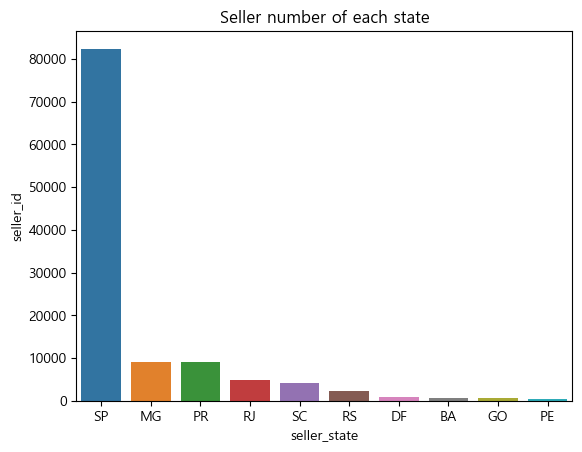

In [372]:
sns.barplot(data = sel_num_state, x = 'seller_state', y='seller_id')
plt.title('Seller number of each state')
plt.xlabel('seller_state')
plt.ylabel('seller_id')
plt.show();

In [331]:
sel_num_city = df_merge.groupby(['seller_state','seller_city']).count()['seller_id'].reset_index().sort_values(by='seller_id', ascending=False).head(10)
sel_num_city.head()

,seller_state,seller_city,seller_id
584,SP,sao paulo,28811
455,SP,ibitinga,8227
567,SP,santo andre,3131
162,PR,curitiba,3033
580,SP,sao jose do rio preto,2667


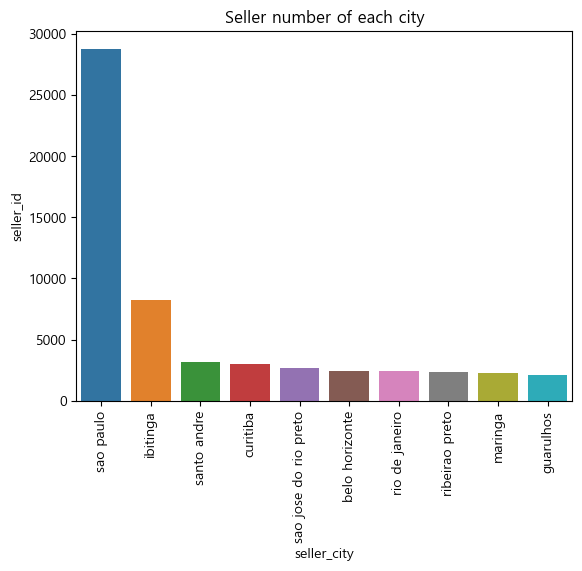

In [373]:
sns.barplot(data = sel_num_city, x ='seller_city', y='seller_id')
plt.title('Seller number of each city')
plt.xlabel('seller_city')
plt.xticks(rotation='vertical')
plt.ylabel('seller_id')
plt.show();

#### number of products people usually order

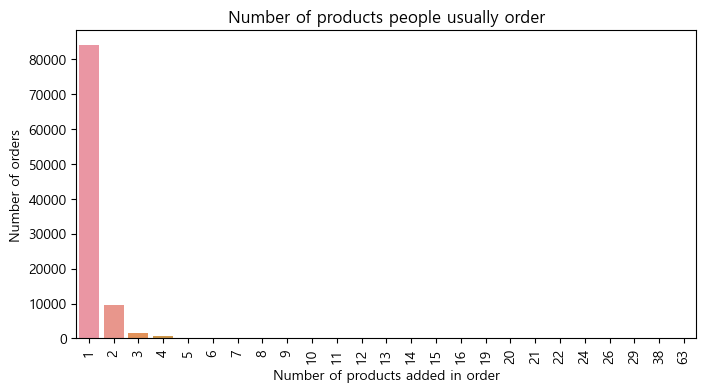

In [375]:
plt.figure(figsize=(8,4))
ax=sns.countplot(x='customer_unique_id', data=customer_id_count)
ax.set_xlabel("Number of products added in order")
ax.set_ylabel("Number of orders")
ax.set_title("Number of products people usually order")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#### Most Bought product categories

In [376]:
product = df_merge.groupby('product_category_name_english').aggregate({'order_id' : 'count'}).rename(columns={'order_id':'order_count'}).sort_values(by='order_count', ascending=False).reset_index()
product.head()

,product_category_name_english,order_count
0,bed_bath_table,11847
1,health_beauty,9944
2,sports_leisure,8942
3,furniture_decor,8743
4,computers_accessories,8105


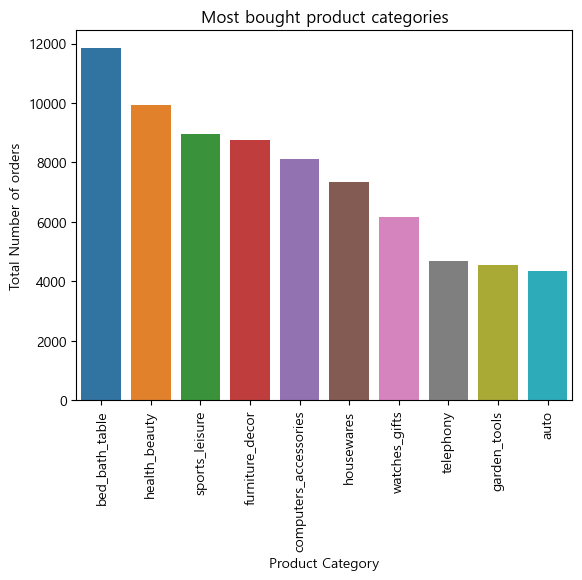

In [333]:
# Visualising top 10 most bought product categories:
sns.barplot(x='product_category_name_english',y='order_count',data=product[:10])
plt.xlabel("Product Category")
plt.ylabel("Total Number of orders")
plt.title("Most bought product categories")
plt.xticks(rotation='vertical')
plt.show()

#### bottom 10 most bought product categories

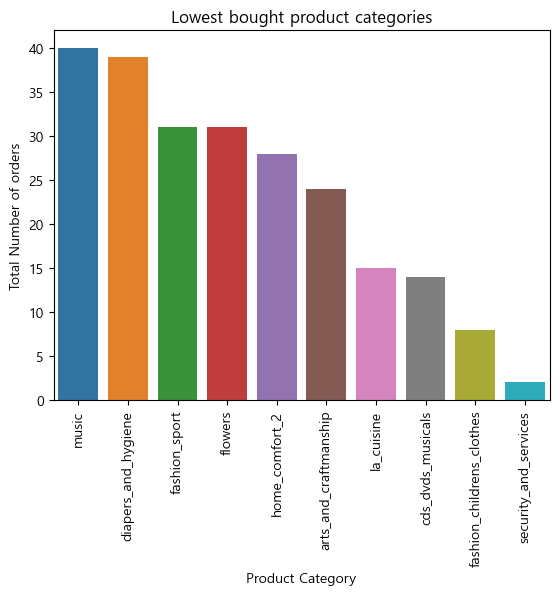

In [334]:
sns.barplot(x='product_category_name_english',y='order_count',data=product[-10:])
plt.xlabel("Product Category")
plt.ylabel("Total Number of orders")
plt.title("Lowest bought product categories")
plt.xticks(rotation='vertical')
plt.show()

#### Seller ID 가장 많은 상품 판 Seller

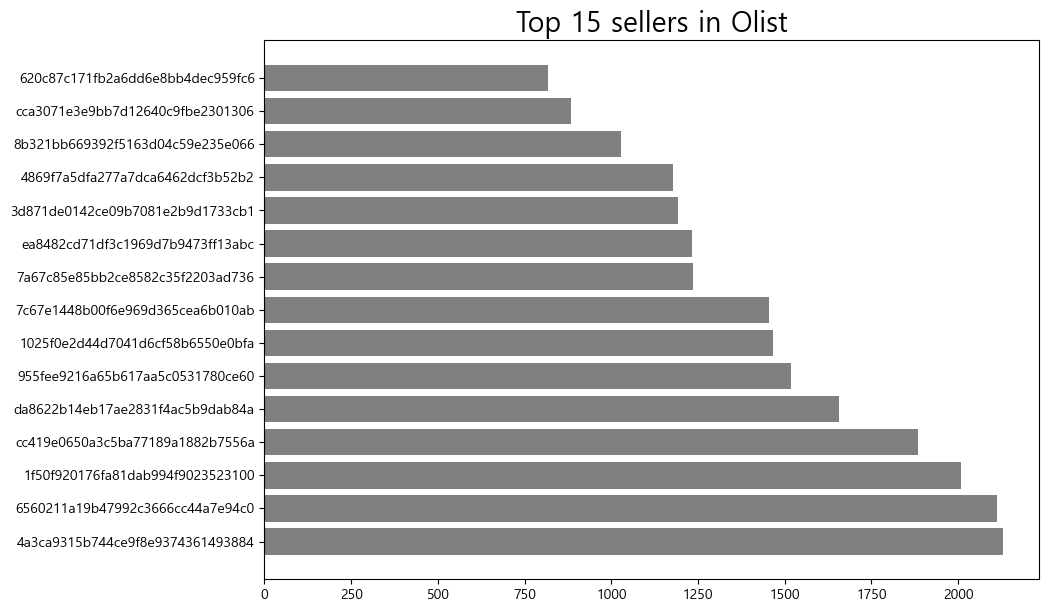

In [335]:
plt.figure(figsize=(10,7))
a = plt.barh(df_merge['seller_id'].value_counts()[:15].index, df_merge['seller_id'].value_counts()[:15].values, color='gray')
plt.title('Top 15 sellers in Olist',fontsize=20)
plt.show()

In [336]:
# - seller 분들의 단골 고객 찾아보기 
# - seller 분들 top, bottom 10 
seller_top1 = df_merge[df_merge['seller_id']=='4a3ca9315b744ce9f8e9374361493884']
seller_top2 = df_merge[df_merge['seller_id']=='6560211a19b47992c3666cc44a7e94c0']
seller_top3 = df_merge[df_merge['seller_id']=='1f50f920176fa81dab994f9023523100']
seller_top4 = df_merge[df_merge['seller_id']=='cc419e0650a3c5ba77189a1882b7556a']
seller_top5 = df_merge[df_merge['seller_id']=='955fee9216a65b617aa5c0531780ce60']
seller_top6 = df_merge[df_merge['seller_id']=='1025f0e2d44d7041d6cf58b6550e0bfa']

Text(0.5, 0.98, 'Top 6 sellers product category')

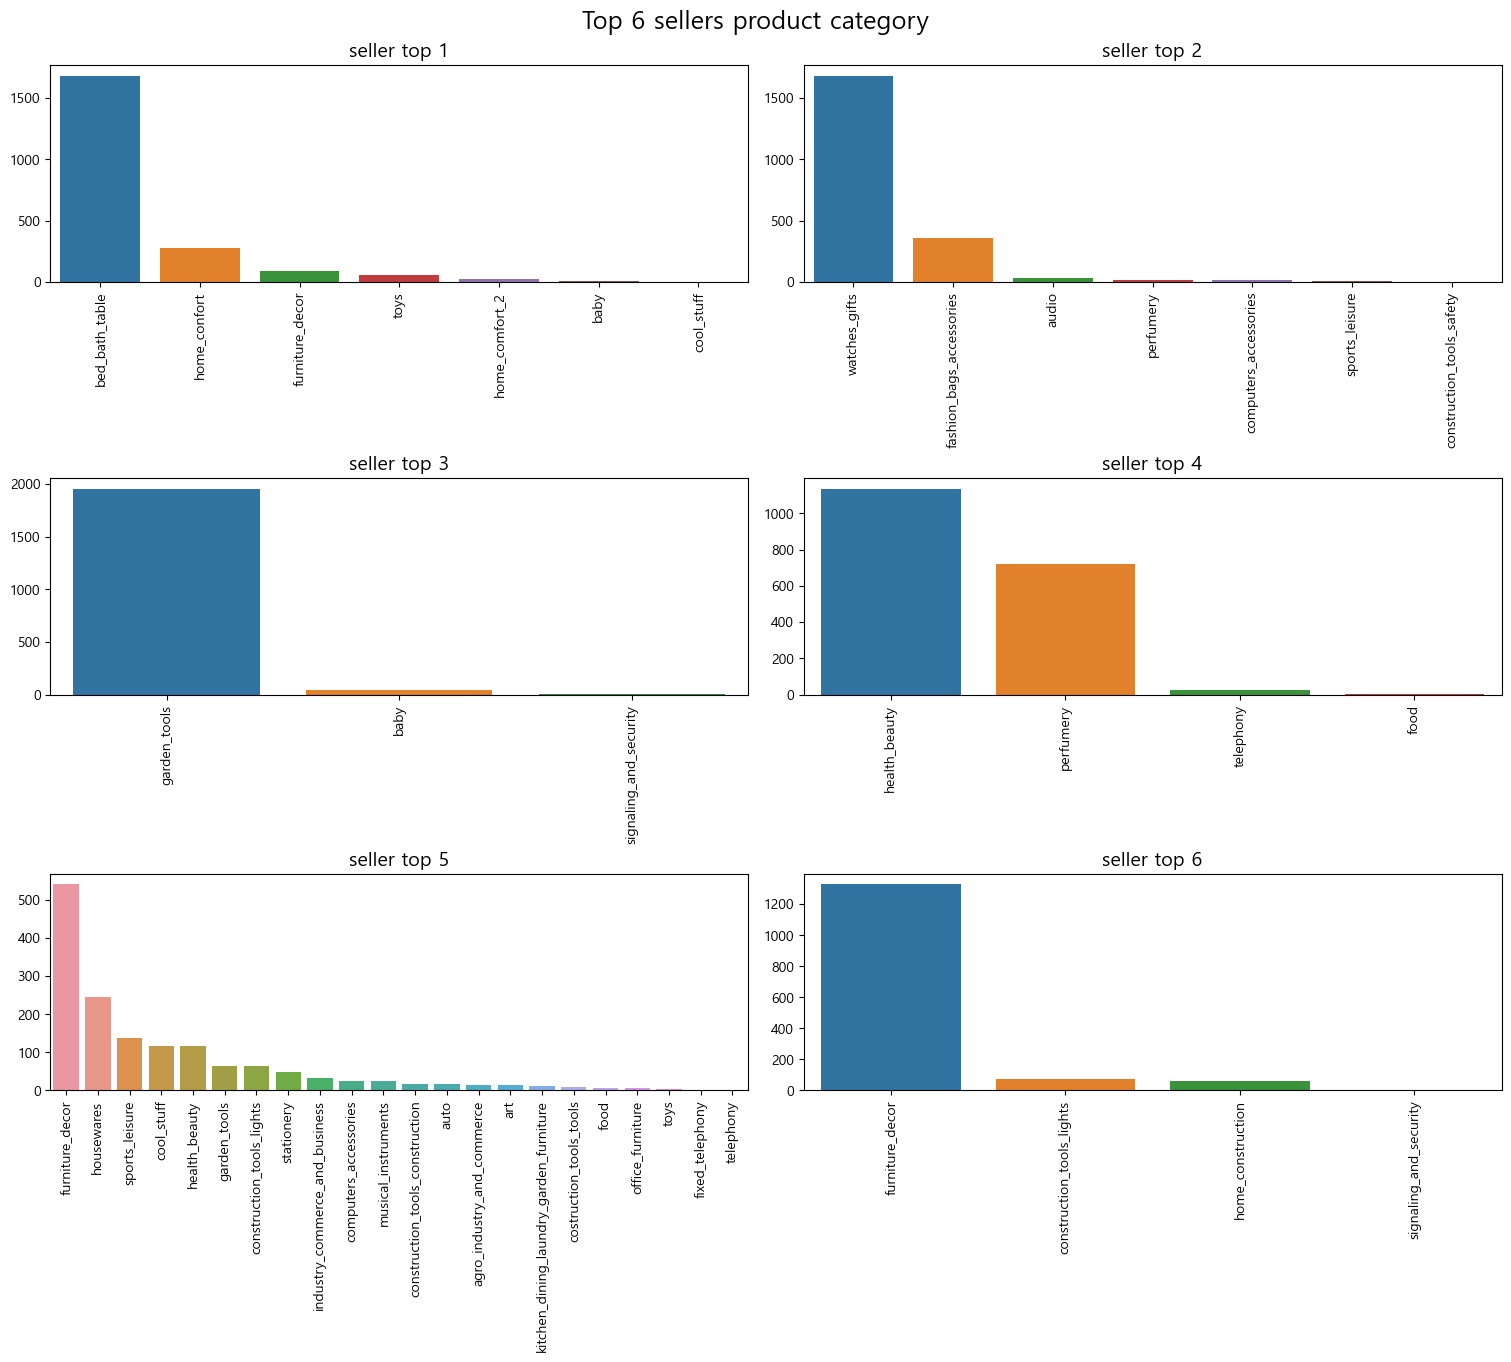

In [337]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(15, 20))

# Axis definition
gs = GridSpec(6, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

colors_list = ['lightskyblue', 'lightgreen']
explode = (0.0, 0.2)

# seller 1
seller_1_gra = sns.barplot(x=seller_top1['product_category_name_english'].value_counts().index, y=seller_top1['product_category_name_english'].value_counts().values,  data=seller_top1, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("seller top 1",size=14, color="black")
seller_1_gra.set_xticklabels(seller_1_gra.get_xticklabels(), rotation=90)

# seller 2
seller_2_gra = sns.barplot(x=seller_top2['product_category_name_english'].value_counts().index, y=seller_top2['product_category_name_english'].value_counts().values,  data=seller_top2, ax=ax2)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title("seller top 2",size=14, color="black")
seller_2_gra.set_xticklabels(seller_2_gra.get_xticklabels(), rotation=90)


# seller 3

seller_3_gra = sns.barplot(x=seller_top3['product_category_name_english'].value_counts().index, y=seller_top3['product_category_name_english'].value_counts().values,  data=seller_top3, ax=ax3)
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.set_title("seller top 3",size=14, color="black")
seller_3_gra.set_xticklabels(seller_3_gra.get_xticklabels(), rotation=90)

# seller 4 

seller_4_gra = sns.barplot(x=seller_top4['product_category_name_english'].value_counts().index, y=seller_top4['product_category_name_english'].value_counts().values,  data=seller_top4, ax=ax4)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.set_title("seller top 4",size=14, color="black")
seller_4_gra.set_xticklabels(seller_4_gra.get_xticklabels(), rotation=90)


# seller 5 

seller_5_gra =sns.barplot(x=seller_top5['product_category_name_english'].value_counts().index, y=seller_top5['product_category_name_english'].value_counts().values,  data=seller_top5, ax=ax5)
ax5.set_xlabel("")
ax5.set_ylabel("")
ax5.set_title("seller top 5",size=14, color="black")
seller_5_gra.set_xticklabels(seller_5_gra.get_xticklabels(), rotation=90)

# seller 6 

seller_6_gra = sns.barplot(x=seller_top6['product_category_name_english'].value_counts().index, y=seller_top6['product_category_name_english'].value_counts().values,  data=seller_top6, ax=ax6)
ax6.set_xlabel("")
ax6.set_ylabel("")
ax6.set_title("seller top 6",size=14, color="black")
seller_6_gra.set_xticklabels(seller_6_gra.get_xticklabels(), rotation=90)


plt.suptitle("Top 6 sellers product category", size=18)

- seller top 6 까지 1~2가지 카테고리가 높은 비중으로 차지하는 경향이 있음. 
- seller top 5의 seller product category 판매 비중이 고루 분포되어있음을 확인. 

#### 상위 10개 상품 매출

In [461]:
total_orders=pd.merge(olist_orders, olist_order_items)
product_orders=pd.merge(total_orders,olist_products, on="product_id")

seller_products = pd.merge(product_orders, olist_sellers, on="seller_id")

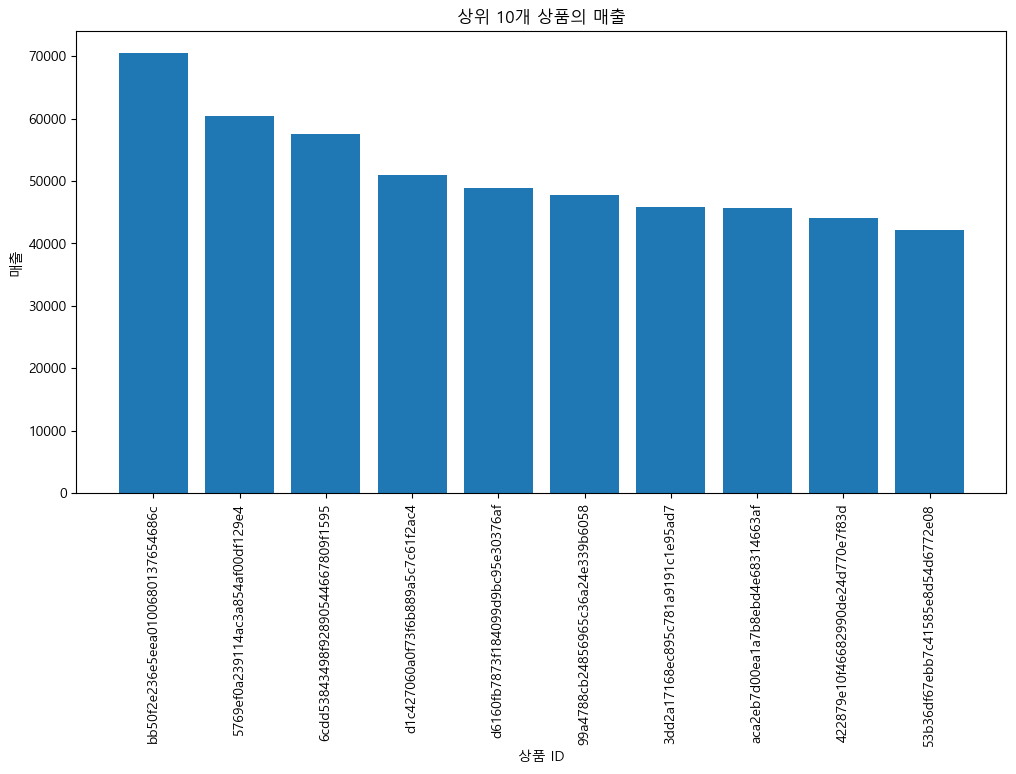

In [462]:
product_orders['revenue'] = product_orders['price'] * product_orders['order_item_id']
top_10_products = product_orders.groupby('product_id')['revenue'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
plt.bar(top_10_products.index, top_10_products.values)
plt.xlabel('상품 ID')
plt.ylabel('매출')
plt.title('상위 10개 상품의 매출')
plt.xticks(rotation=90)
plt.show()

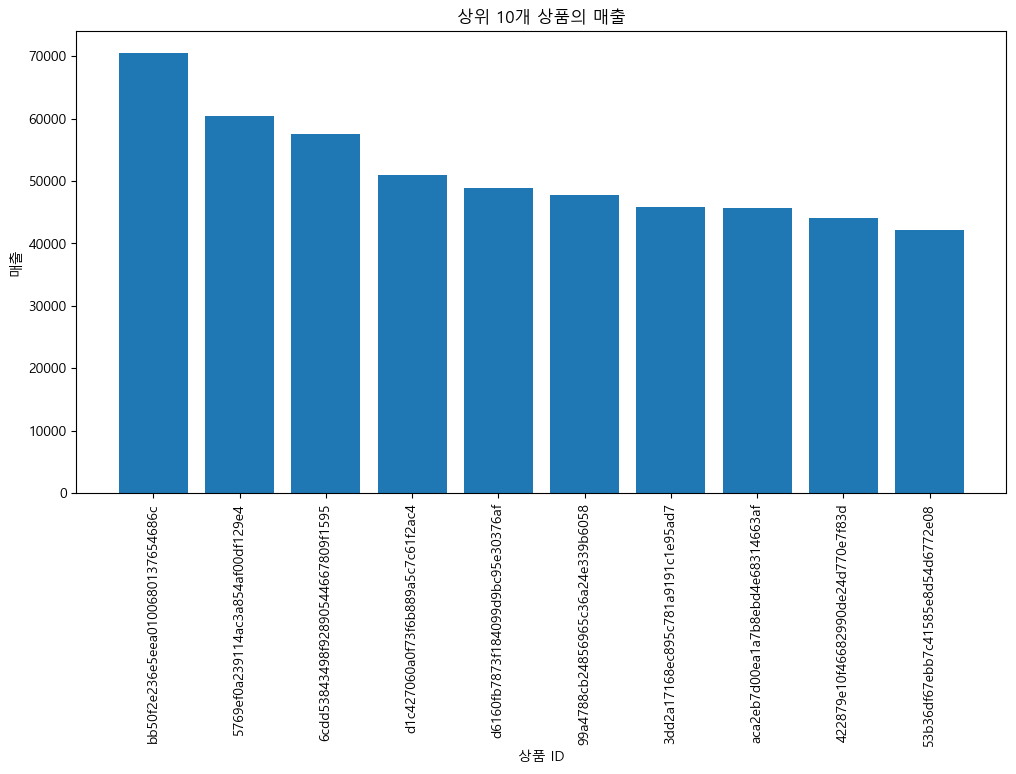

In [463]:
product_orders['revenue'] = product_orders['price'] * product_orders['order_item_id']
top_10_products = product_orders.groupby('product_id')['revenue'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
plt.bar(top_10_products.index, top_10_products.values)
plt.xlabel('상품 ID')
plt.ylabel('매출')
plt.title('상위 10개 상품의 매출')
plt.xticks(rotation=90)
plt.show()

#### 상위 10개 상품 판매량

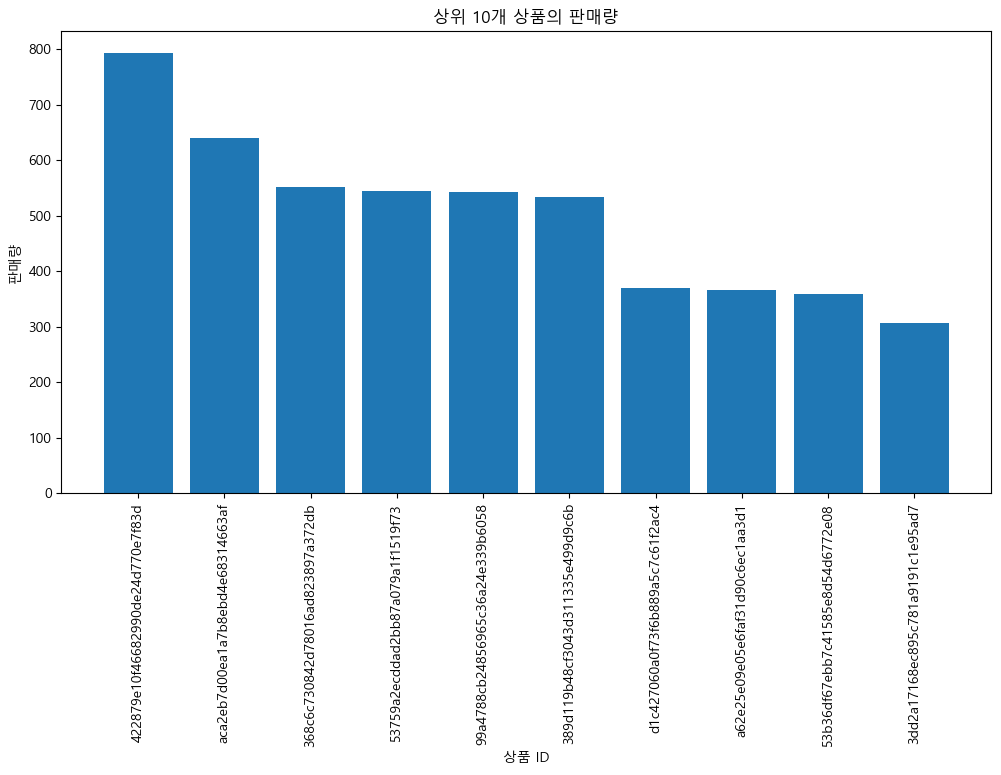

In [464]:
product_sales = product_orders.groupby('product_id')['order_item_id'].sum()
top_10_products = product_sales.nlargest(10)
plt.figure(figsize=(12, 6))
plt.bar(top_10_products.index, top_10_products.values)
plt.xlabel('상품 ID')
plt.ylabel('판매량')
plt.title('상위 10개 상품의 판매량')
plt.xticks(rotation=90)
plt.show()


- 매출 상위 10개 제품과 판매 상위 10개 제품의 목록이 일치하지 않는다. 

- 가장 주문이 많은 카테고리는 bed_table_bath지만, 가장 많이 매출이 높은 카테고리는 health_beauty이다.

#### 판매자별 판매량 계산(상위 10위)

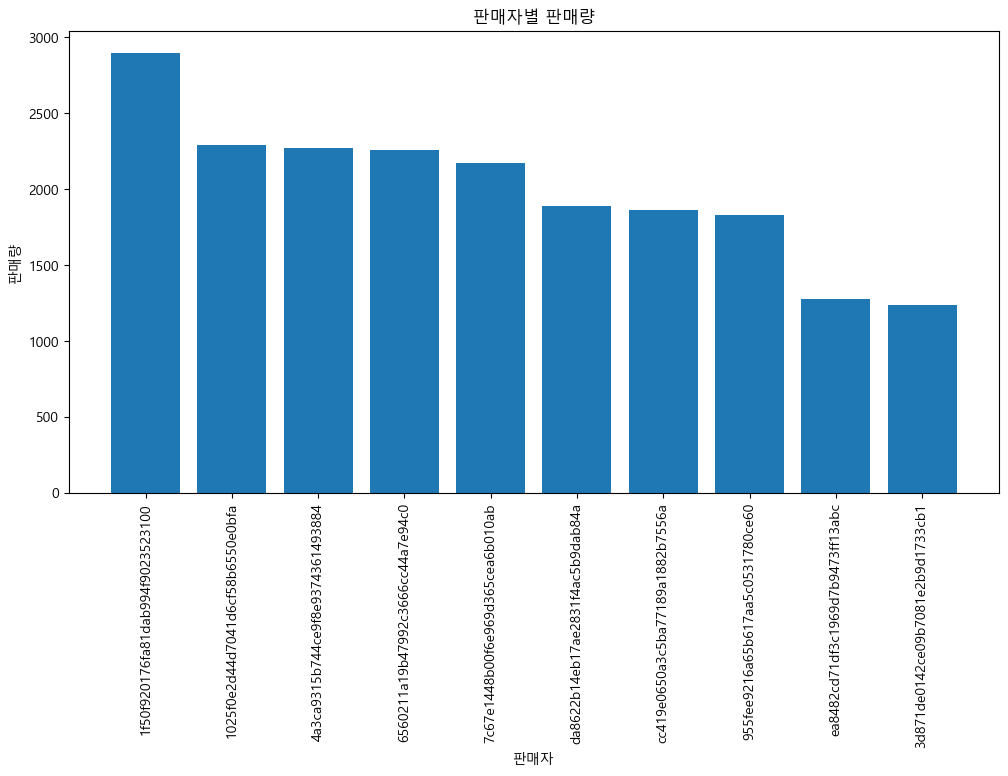

In [342]:
seller_sales = seller_products.groupby('seller_id')['order_item_id'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(seller_sales.index, seller_sales.values)
plt.xlabel('판매자')
plt.ylabel('판매량')
plt.title('판매자별 판매량')
plt.xticks(rotation=90)
plt.show()


#### 판매자별 매출 계산

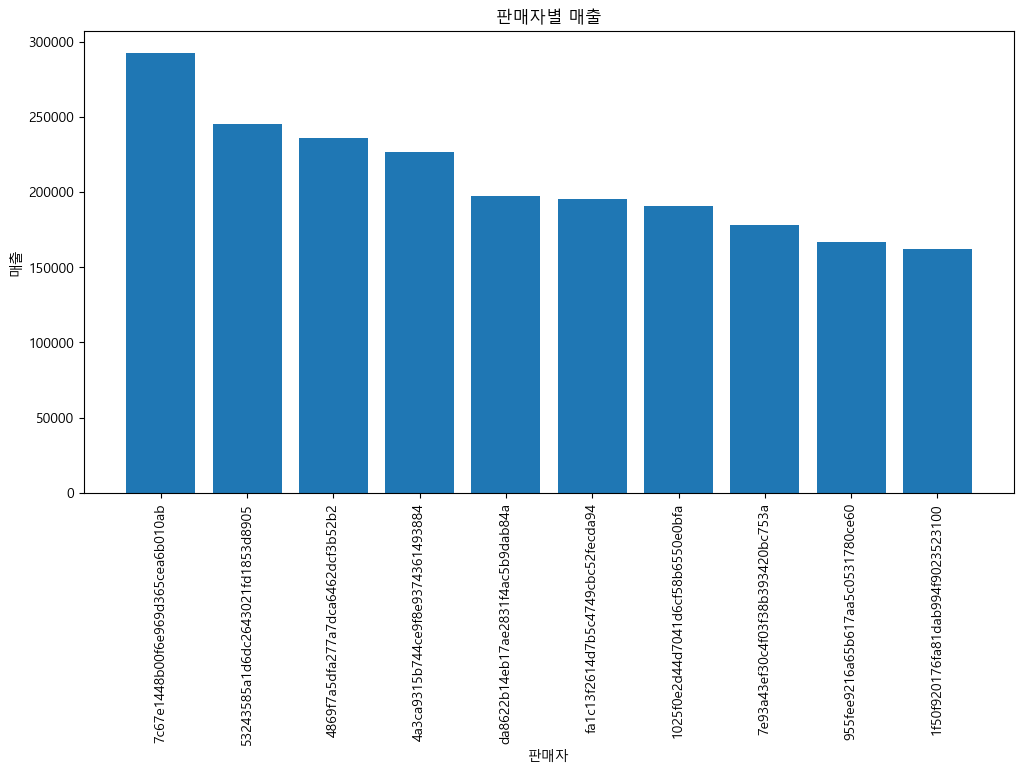

In [343]:
seller_products['revenue'] = seller_products['price'] * seller_products['order_item_id']

seller_revenue=seller_products.groupby('seller_id')['revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(seller_revenue.index, seller_revenue.values)
plt.xlabel('판매자')
plt.ylabel('매출')
plt.title('판매자별 매출')
plt.xticks(rotation=90)
plt.show()


#### 지역별 판매자 수 계산

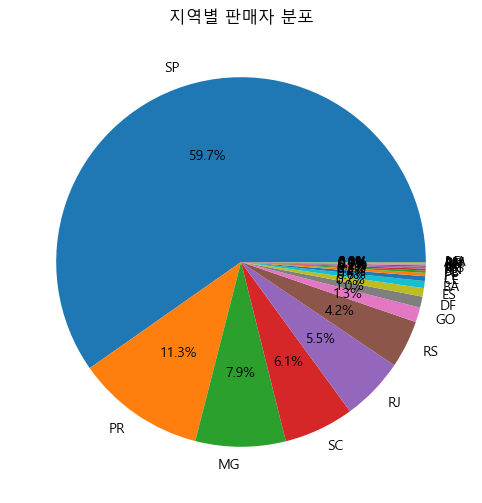

In [344]:
unique_sellers = seller_products.drop_duplicates(subset='seller_id')
seller_counts = unique_sellers['seller_state'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(seller_counts.values, labels=seller_counts.index, autopct='%1.1f%%')
plt.title('지역별 판매자 분포')
plt.show()



- 판매자는 SP(상파울루)에 59.7% 분하고 있으며 상위 5개지역에 약 90%의 판매자가 분포하고 있다.

#### 판매자별 평균 평점 계산

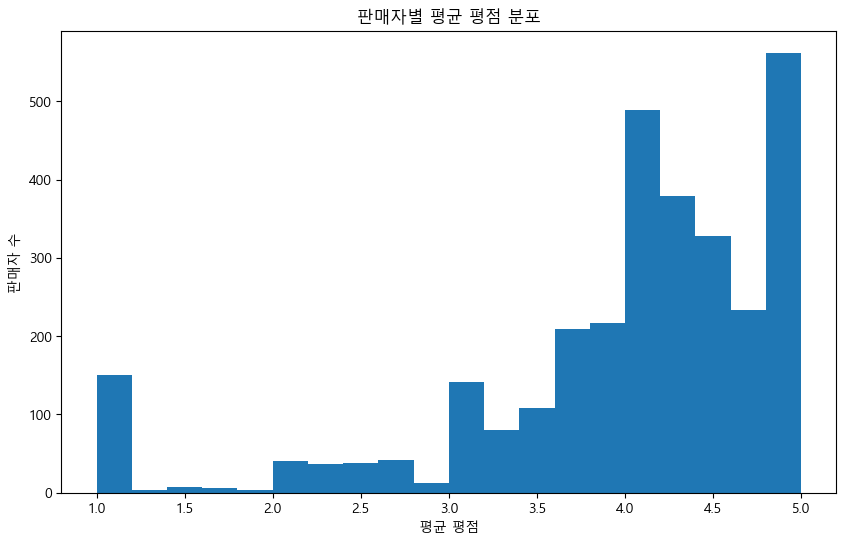

In [346]:
seller_avg_rating = merged_df_jb.groupby('seller_id')['review_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.hist(seller_avg_rating, bins=20)
plt.xlabel('평균 평점')
plt.ylabel('판매자 수')
plt.title('판매자별 평균 평점 분포')
plt.show()


#### tax와 review_score, price, freight_value, customer_state_code, seller_state_code, customer unique id

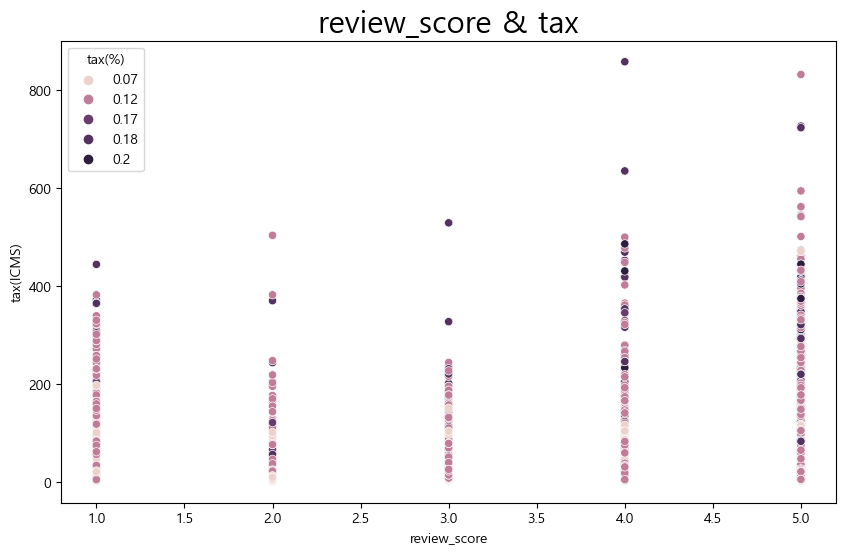

In [256]:
x = df_merge['review_score']
y = df_merge['tax(ICMS)']

plt.figure(figsize=(10,6))
plt.title('review_score & tax', fontsize=22)
s1 = sns.scatterplot(x=x, y=y, hue='tax(%)', data=df_merge)

# plt.xlabel('price', fontsize=17)
# plt.ylabel('tax(ICMS)', fontsize=17)
plt.show()

- 유류세
- 브라질에서 출판물을 제외한 우편화물의 경우 과세 대상 금액(상품가격 + 운송비 + 보험료)에 대해 일률적으로 세금 부과 
- 상품 유통 서비스세를 부과 

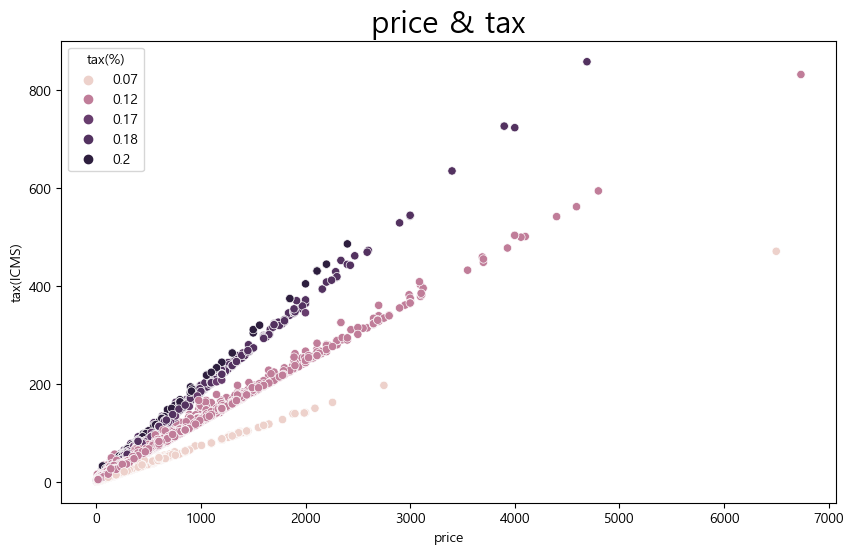

In [347]:
x = df_merge['price']
y = df_merge['tax(ICMS)']

plt.figure(figsize=(10,6))
plt.title('price & tax', fontsize=22)
s1 = sns.scatterplot(x=x, y=y, hue='tax(%)', data=df_merge)

# plt.xlabel('price', fontsize=17)
# plt.ylabel('tax(ICMS)', fontsize=17)
plt.show()

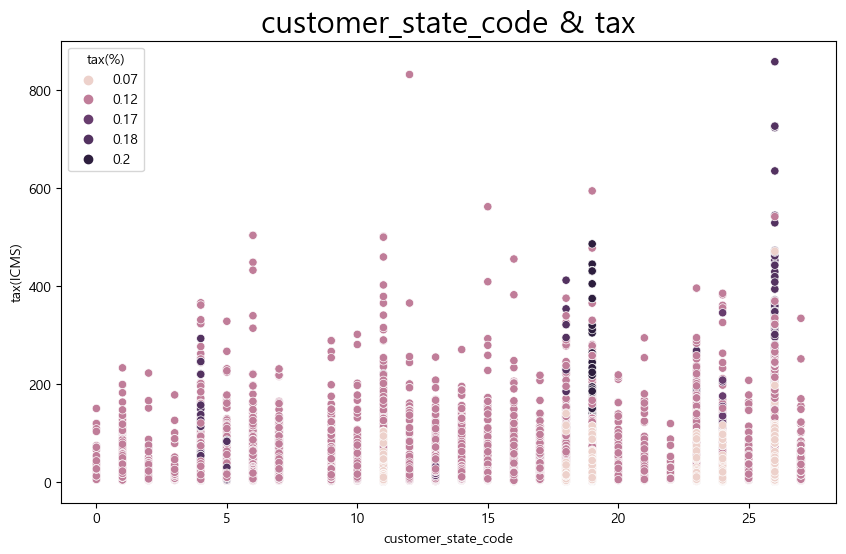

In [349]:
x = df_merge['customer_state_code']
y = df_merge['tax(ICMS)']

plt.figure(figsize=(10,6))
plt.title('customer_state_code & tax', fontsize=22)
s1 = sns.scatterplot(x=x, y=y, hue='tax(%)', data=df_merge)

# plt.xlabel('price', fontsize=17)
# plt.ylabel('tax(ICMS)', fontsize=17)
plt.show()

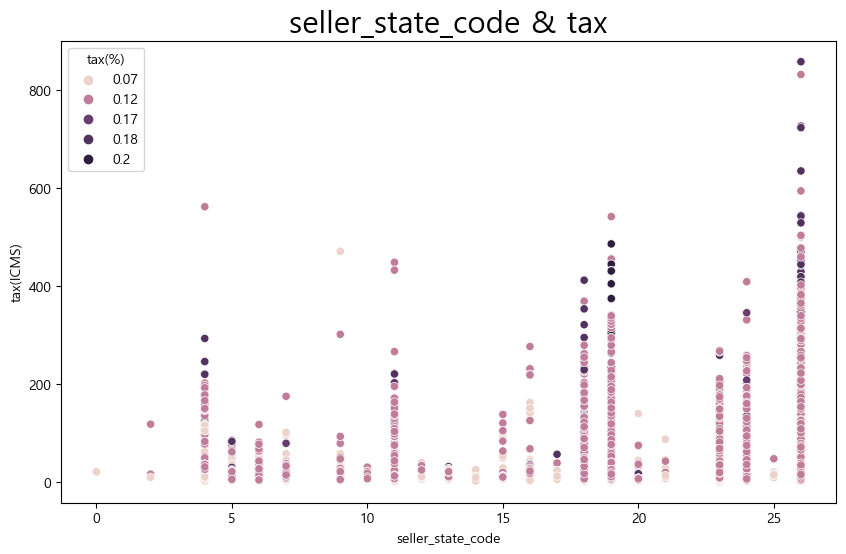

In [260]:
x = df_merge['seller_state_code']
y = df_merge['tax(ICMS)']

plt.figure(figsize=(10,6))
plt.title('seller_state_code & tax', fontsize=22)
s1 = sns.scatterplot(x=x, y=y, hue='tax(%)', data=df_merge)

# plt.xlabel('price', fontsize=17)
# plt.ylabel('tax(ICMS)', fontsize=17)
plt.show()

---